## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import tensorflow.keras as keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/Users/ttyoung/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
x_train = x_train[:5000]
x_test = x_test[:5000]
y_train = y_train[:5000]
y_test = y_test[:5000]

In [13]:
# from tensorflow.keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
#             x = keras.layers.Dropout(drp_ratio)(x) ## dropout function has bug: https://github.com/tensorflow/tensorflow/issues/23410
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
#             x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.1, 0.25, 0.5]

In [17]:
results = {}
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for dropout_exp in Dropout_EXP:
    try:
        keras.backend.clear_session() # 把舊的 Graph 清掉
    except:
        pass
    print("Experiment with LR = %.6f" % (LEARNING_RATE))
    model = build_mlp(input_shape=x_train.shape[1:],drp_ratio=dropout_exp)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-dropout-{dropout_exp}".format(dropout_exp=dropout_exp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with LR = 0.001000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] 

Train on 5000 samples, validate on 5000 samples
Epoch 1/50
5000/5000 [==============================] - 1s 261us/step - loss: 2.4816 - acc: 0.1406 - val_loss: 2.1590 - val_acc: 0.1994
Epoch 2/50
5000/5000 [==============================] - 1s 186us/step - loss: 2.0744 - acc: 0.2296 - val_loss: 2.0058 - val_acc: 0.2742
Epoch 3/50
5000/5000 [==============================] - 1s 187us/step - loss: 1.9690 - acc: 0.2716 - val_loss: 1.9479 - val_acc: 0.3056
Epoch 4/50
5000/5000 [==============================] - 1s 187us/step - loss: 1.9305 - acc: 0.2968 - val_loss: 1.9156 - val_acc: 0.3166
Epoch 5/50
5000/5000 [==============================] - 1s 187us/step - loss: 1.8596 - acc: 0.3320 - val_loss: 1.8697 - val_acc: 0.3440
Epoch 6/50
5000/5000 [==============================] - 1s 187us/step - loss: 1.8169 - acc: 0.3504 - val_loss: 1.8755 - val_acc: 0.3298
Epoch 7/50
5000/5000 [==============================] - 1s 188us/step - loss: 1.7844 - acc: 0.3658 - val_loss: 1.8159 - val_acc: 0.3454


5000/5000 [==============================] - 1s 190us/step - loss: 2.0346 - acc: 0.2510 - val_loss: 2.0101 - val_acc: 0.2806
Epoch 3/50
5000/5000 [==============================] - 1s 189us/step - loss: 1.9307 - acc: 0.3058 - val_loss: 1.9549 - val_acc: 0.3118
Epoch 4/50
5000/5000 [==============================] - 1s 188us/step - loss: 1.8733 - acc: 0.3278 - val_loss: 1.9065 - val_acc: 0.3354
Epoch 5/50
5000/5000 [==============================] - 1s 188us/step - loss: 1.8205 - acc: 0.3434 - val_loss: 1.8422 - val_acc: 0.3438
Epoch 6/50
5000/5000 [==============================] - 1s 189us/step - loss: 1.7856 - acc: 0.3658 - val_loss: 1.8658 - val_acc: 0.3344
Epoch 7/50
5000/5000 [==============================] - 1s 188us/step - loss: 1.7489 - acc: 0.3718 - val_loss: 1.7986 - val_acc: 0.3596
Epoch 8/50
5000/5000 [==============================] - 1s 188us/step - loss: 1.7130 - acc: 0.3836 - val_loss: 1.8225 - val_acc: 0.3570
Epoch 9/50
5000/5000 [==============================] - 1s 

In [19]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


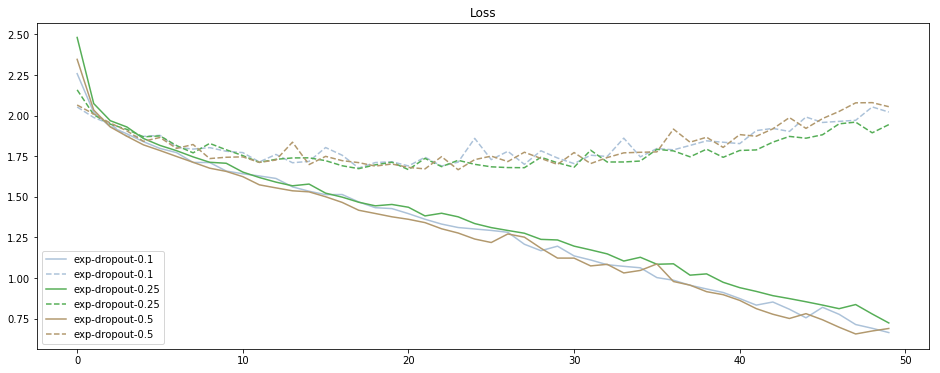

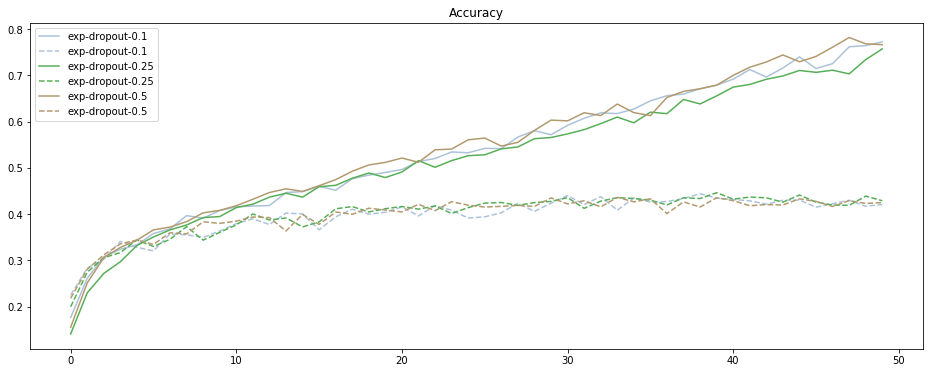

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = colors_list

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()